In [1]:
import numpy as np
import matplotlib.pyplot as plt

from include.load_data.get_counts import get_real_counts

from include.build_synth import buildData_fromRO as build

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE

from importlib import reload
reload(RtM), reload(LL)

np.random.seed(2025)

## Disconnected complete graphs
Define spatial clusters as disconnected complete graphs, with equal reproduction number in each cluster

In [2]:
cluster_sizes = [2,3,2]
nclusters = len(cluster_sizes)

firstDay, lastDay = "2020-12-01", "2021-02-25"
dataBasis = 'JHU'
countries = ['France', 'Canada', 'Japan', 'Thailand', 'Austria']

if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))

In [3]:
# get number of new cases for each cluster (i.e. each country)
ZData_by_cluster = []
for i in range(nclusters):
    ZData, options = get_real_counts(countries[i], firstDay, lastDay, dataBasis)
    ZData_by_cluster.append(ZData)
optionsZ = options

# infer the reproduction number for each of these clusters
lambdaU_L = 3.5
lambdaU_O = 0.03
R_by_cluster, O_by_cluster, options_UO = Rt_U_O(ZData_by_cluster, lambdaU_L, lambdaU_O, options=options)

Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Computing Univariate estimation with O misreported counts modelisation ...
Done in 21.8077 seconds ---


First day : 2020-12-01 
 Last day : 2021-02-25


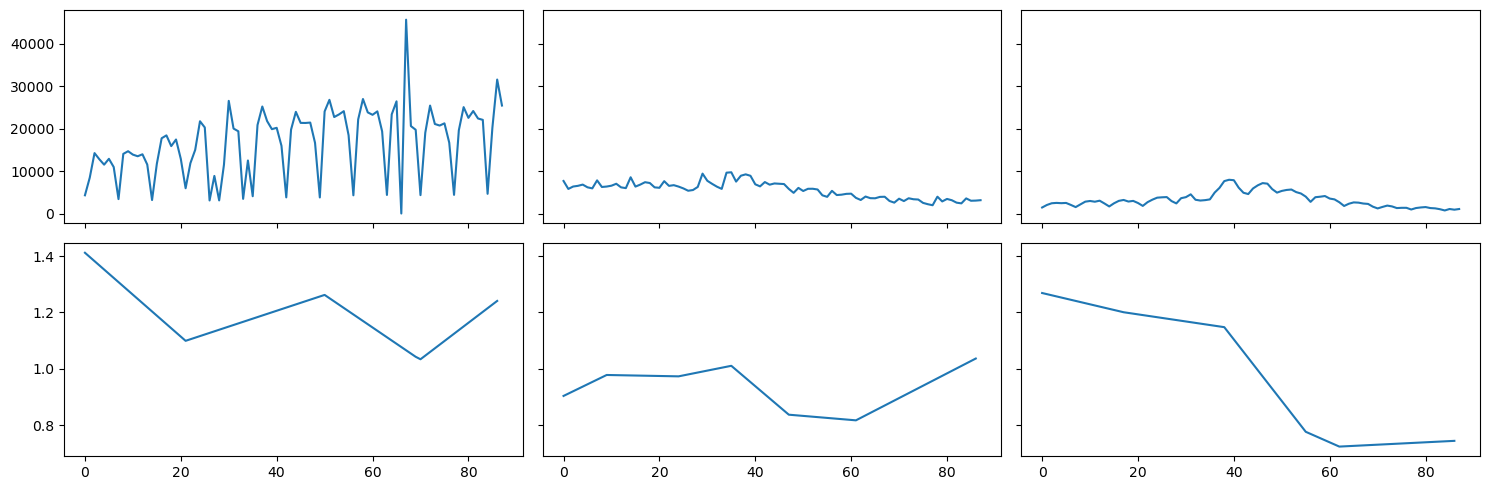

In [4]:
fig, axs = plt.subplots(2,nclusters, figsize=(15,5), sharex=True, sharey="row")
for i in range(len(cluster_sizes)):
    axs[0,i].plot(ZData_by_cluster[i])
    axs[1,i].plot(R_by_cluster[i])
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

## Generate ZData 
For each country, we generate new cases counts according to the reproduction number of their cluster

In [5]:
alpha_c = 0.01
ZData_by_country = []
for i in range(nclusters):
    for _ in range(cluster_sizes[i]):
        firstCases = np.random.poisson(ZData_by_cluster[i][0])
        alpha = alpha_c*ZData_by_cluster[i][0]
        ZData, options = build.buildData_anyRO(R_by_cluster[i,:], O_by_cluster[i,:], firstCases, firstDay, alpha=alpha)
        ZData_by_country.append(ZData)
ZData_by_country = np.array(ZData_by_country)

#add noise to ZData
# n,m = ZData_by_country.shape
# ZData_by_country = ZData_by_country +  ZData_by_country[:,0][None, :]/50 @ np.random.poisson(1, (n,m))*(2*np.random.randint(0,2,(n,m))-1)

First day : 2020-12-01 
 Last day : 2021-02-25


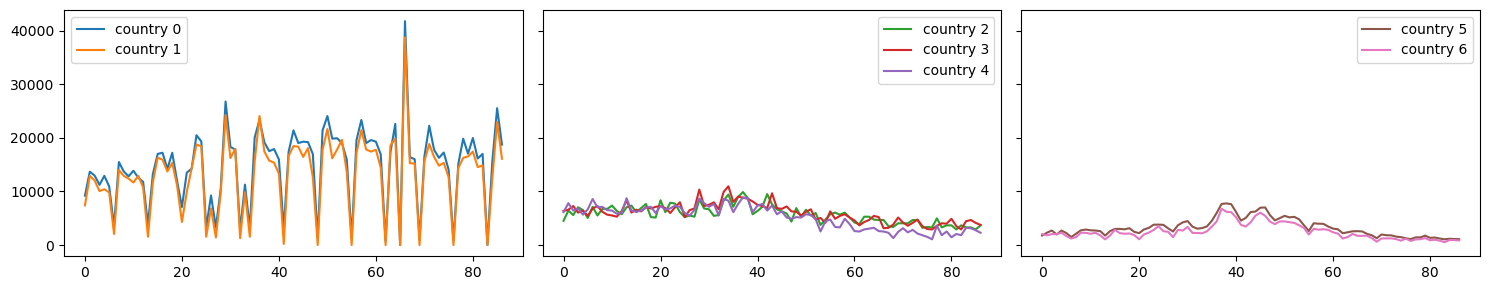

In [6]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True, sharey="row")
k = 0
for i in range(len(cluster_sizes)):
    for _ in range(cluster_sizes[i]):
        axs[i].plot(ZData_by_country[k], color=colors[k], label="country {}".format(k))
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [7]:

n_max_iter = 3

#init param
lambdaU_pwlin = 20
# lambdaU_O = 0.02

#optim param
lambda_Fro = 0.25
lambda_GR = 2
lambda_pwlin = 20
Gregularization="L2"

Z = ZData_by_country
dates = options["dates"]

Restims = []
Lestims = []


# initialize
R = myRt_U(Z, lambdaU_pwlin, options=options)
# R = []
# for i in range(Z.shape[0]):
#     Ri, _ = RtMLE.Rt_MLE(Z[i], options=options)
#     R.append(Ri)
# R = np.array(R)

Restims.append(R)
for iter in range(n_max_iter):
    L = LL.learningL(lambda_GR, lambda_Fro, R)
    R = RtM.Rt_with_laplacianReg(ZData_by_country, L, lambda_pwlin, lambda_GR, Gregularization, dates)
    Lestims.append(L)
    Restims.append(R)

Computing Univariate estimator ...
Done in 7.6699 seconds ---
Precomputations done in 0.001
QP solution computed in 0.0038237571716308594
Computing a Cholesky decomposition of L ...
Done in 0.000 seconds ---
Computing Multivariate estimator ...
use prox L2
Done in 28.4757 seconds ---
Precomputations done in 0.000
QP solution computed in 0.0009560585021972656
Computing a Cholesky decomposition of L ...
Done in 0.000 seconds ---
Computing Multivariate estimator ...
use prox L2
Done in 29.1089 seconds ---
Precomputations done in 0.000
QP solution computed in 0.0009453296661376953
Computing a Cholesky decomposition of L ...
Done in 0.000 seconds ---
Computing Multivariate estimator ...
use prox L2
Done in 29.1836 seconds ---


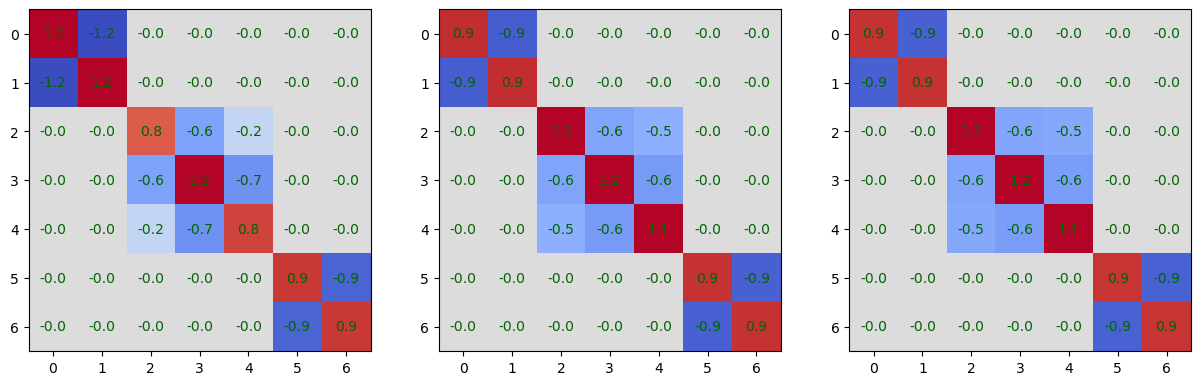

In [8]:
n = Lestims[0].shape[0]
fig, axs = plt.subplots(1, n_max_iter, figsize=(15,5), squeeze=False)
for L, ax in zip(Lestims, axs[0]):
    ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
    for i in range(n):
        for j in range(n):
            c = L[i,j]
            ax.text(i, j, "{:2.1f}".format(c), va='center', ha='center', color="darkgreen")

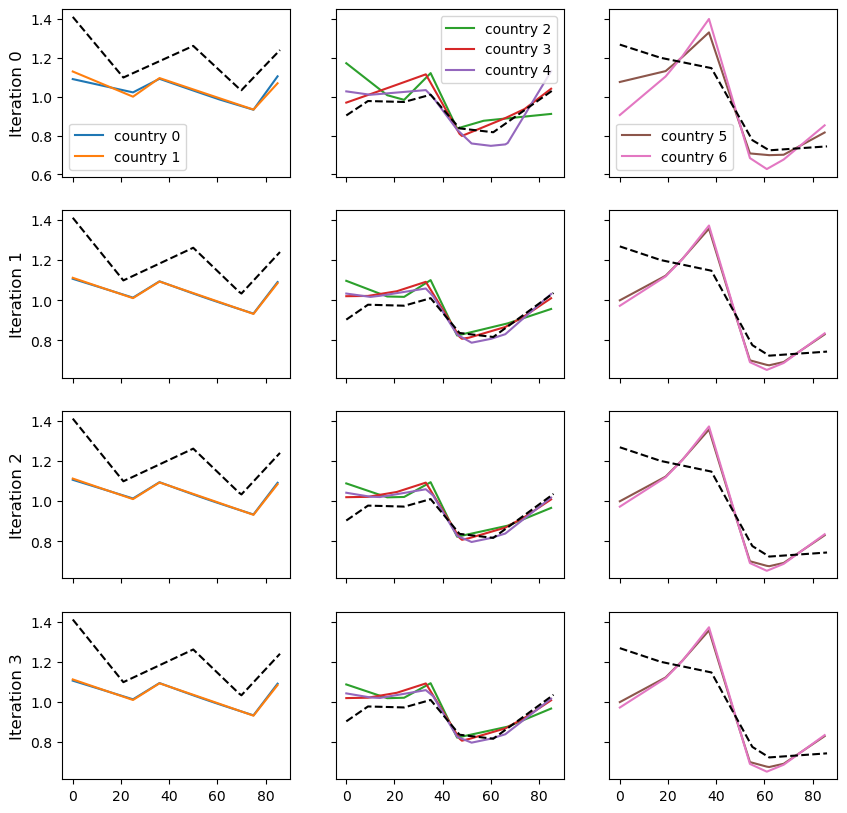

In [9]:
fig, axs = plt.subplots(n_max_iter+1, nclusters, figsize=(10,10), sharex=True, sharey="row", squeeze=False)
for i in range(n_max_iter+1):
    k = 0
    for j in range(nclusters):
        for _ in range(cluster_sizes[j]):
            axs[i,j].plot(Restims[i][k], color=colors[k], label="country {}".format(k))
            # axs[i,j].plot(Restims[i][k], ':', color=colors[k])
            k+=1
        axs[i,j].plot(R_by_cluster[j], 'k--')
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iteration {}".format(i), fontsize=12)
plt.show()